# 02 - Simulator Overview

This notebook provides an architectural overview of the trading simulator: key components, data flow, and extensibility points.

Objectives:
- Understand the main building blocks (MarketData, ExecutionEngine, Strategy, Risk, Metrics).
- See how events flow through the system.
- Interactively explore parameters of the core loop.

## High-level Architecture Diagram
The diagram below shows the primary components and their interactions.

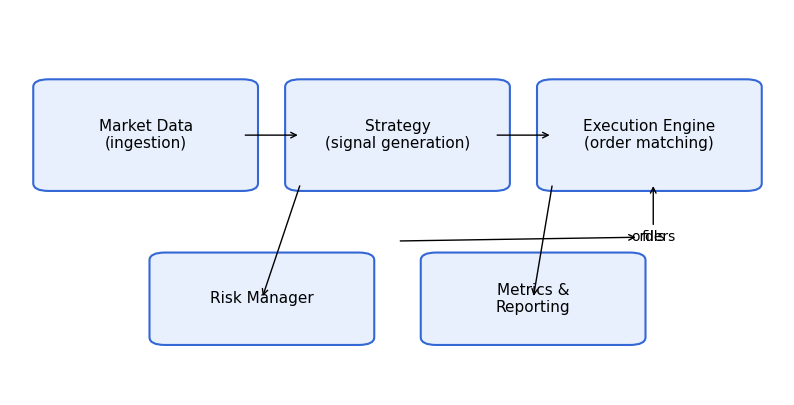

In [1]:
# Diagram using matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')

def box(x, y, w, h, label, fc='#e8f0fe'):
    rect = patches.FancyBboxPatch((x, y), w, h, boxstyle='round,pad=0.02',
                                   linewidth=1.5, edgecolor='#3367d6', facecolor=fc)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=11)

# Boxes
box(0.05, 0.55, 0.25, 0.25, 'Market Data\n(ingestion)')
box(0.375, 0.55, 0.25, 0.25, 'Strategy\n(signal generation)')
box(0.70, 0.55, 0.25, 0.25, 'Execution Engine\n(order matching)')
box(0.20, 0.15, 0.25, 0.20, 'Risk Manager')
box(0.55, 0.15, 0.25, 0.20, 'Metrics &\nReporting')

# Arrows
ax.annotate('', xy=(0.375, 0.675), xytext=(0.30, 0.675), arrowprops=dict(arrowstyle='->'))
ax.annotate('', xy=(0.70, 0.675), xytext=(0.625, 0.675), arrowprops=dict(arrowstyle='->'))
ax.annotate('orders', xy=(0.83, 0.55), xytext=(0.83, 0.40),
            arrowprops=dict(arrowstyle='->'), ha='center')
ax.annotate('fills', xy=(0.50, 0.40), xytext=(0.83, 0.40),
            arrowprops=dict(arrowstyle='<-'), ha='center')
ax.annotate('', xy=(0.325, 0.25), xytext=(0.375, 0.55), arrowprops=dict(arrowstyle='->'))
ax.annotate('', xy=(0.675, 0.25), xytext=(0.70, 0.55), arrowprops=dict(arrowstyle='->'))

plt.show()

## Minimal Simulator Skeleton
This is a tiny, self-contained skeleton that mirrors the architecture at a high level.

In [2]:
from dataclasses import dataclass
from typing import List, Dict
import numpy as np

class MarketData:
    def __init__(self, prices):
        self.prices = prices
        self.t = 0
    def step(self):
        if self.t >= len(self.prices):
            return None
        p = self.prices[self.t]
        self.t += 1
        return p

class Strategy:
    def __init__(self, lookback=5, threshold=0.0):
        self.lookback = lookback
        self.threshold = threshold
        self.buffer: List[float] = []
    def on_price(self, price):
        self.buffer.append(price)
        if len(self.buffer) < self.lookback:
            return 0
        ret = (self.buffer[-1] - self.buffer[-self.lookback]) / self.buffer[-self.lookback]
        if ret > self.threshold:
            return 1
        elif ret < -self.threshold:
            return -1
        return 0

class ExecutionEngine:
    def __init__(self, slippage_bps=1):
        self.slippage_bps = slippage_bps
        self.position = 0
        self.cash = 0.0
    def execute(self, signal, price):
        if signal == 0:
            return 0.0
        fill = price * (1 + np.sign(signal) * self.slippage_bps/10000.0)
        self.position += signal
        self.cash -= signal * fill
        return fill

def run(prices, lookback=5, threshold=0.0, slippage_bps=1):
    md = MarketData(prices)
    strat = Strategy(lookback, threshold)
    exe = ExecutionEngine(slippage_bps)
    pnl = []
    last_price = None
    while True:
        p = md.step()
        if p is None:
            break
        sig = strat.on_price(p)
        exe.execute(sig, p)
        if last_price is not None:
            # mark-to-market
            mtm = exe.position * (p - last_price)
        else:
            mtm = 0.0
        pnl.append(exe.cash + exe.position * p)
        last_price = p
    return pnl

# Demo
np.random.seed(0)
prices = 100 + np.cumsum(np.random.randn(500))
pnl = run(prices, lookback=10, threshold=0.01, slippage_bps=2)
len(pnl), pnl[-1] if pnl else None

(500, np.float64(-0.47339812125937897))

## Interactive Parameters
Use the widgets to tune parameters and observe changes in output PnL.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import ipywidgets as widgets
    from ipywidgets import interact
except Exception as e:
    widgets = None
    interact = None

np.random.seed(1)
prices = 100 + np.cumsum(np.random.randn(600))

def simulate(lookback=10, threshold=0.01, slippage_bps=2):
    pnl = run(prices, lookback=lookback, threshold=threshold, slippage_bps=slippage_bps)
    plt.figure(figsize=(8,3))
    plt.plot(pnl)
    plt.title(f'PnL | lookback={lookback}, threshold={threshold}, slippage={slippage_bps} bps')
    plt.xlabel('Step')
    plt.ylabel('Equity')
    plt.grid(True)
    plt.show()

if interact is not None:
    interact(simulate, lookback=(2,50,1), threshold=(0.0,0.05,0.005), slippage_bps=(0,10,1))
else:
    simulate()


interactive(children=(IntSlider(value=10, description='lookback', max=50, min=2), FloatSlider(value=0.01, desc…

## Exercises
1. Add a transaction cost model with both fixed and proportional fees.
2. Extend the Strategy to support short-circuit exits when momentum reverses.
3. Add a simple Risk Manager that caps maximum position size.

Solutions are toggleable below.

In [4]:
# Toggle solutions
show_solutions = False
try:
    import ipywidgets as widgets
    show_btn = widgets.ToggleButton(value=False, description='Show Solutions')
    display(show_btn)
    def _observe(change):
        global show_solutions
        show_solutions = change['new']
    show_btn.observe(_observe, 'value')
except Exception:
    pass

if show_solutions:
    from dataclasses import dataclass
    import numpy as np
    class ExecutionEngineV2(ExecutionEngine):
        def __init__(self, slippage_bps=1, fee_fixed=0.0, fee_bps=0.0):
            super().__init__(slippage_bps)
            self.fee_fixed = fee_fixed
            self.fee_bps = fee_bps
        def execute(self, signal, price):
            if signal == 0: return 0.0
            fill = price * (1 + np.sign(signal) * self.slippage_bps/10000.0)
            fee = self.fee_fixed + abs(signal) * fill * (self.fee_bps/10000.0)
            self.position += signal
            self.cash -= signal * fill + fee
            return fill
    class StrategyV2(Strategy):
        def on_price(self, price):
            signal = super().on_price(price)
            # exit if sign flips vs last step
            if len(self.buffer) > self.lookback:
                mom_prev = (self.buffer[-2] - self.buffer[-1-self.lookback]) / self.buffer[-1-self.lookback]
                mom_now = (self.buffer[-1] - self.buffer[-self.lookback]) / self.buffer[-self.lookback]
                if mom_prev * mom_now < 0:
                    return 0
            return signal
    'Solutions loaded'
else:
    'Toggle the button to show solutions'


ToggleButton(value=False, description='Show Solutions')

## Performance Benchmarks
We'll compare a naive Python loop vs. vectorized numpy for a moving return calculation.

In [5]:
import numpy as np
prices = 100 + np.cumsum(np.random.randn(20000))
LB = 20

def moving_return_loop(x, lb):
    out = np.zeros_like(x)
    for i in range(lb, len(x)):
        out[i] = (x[i]-x[i-lb])/x[i-lb]
    return out

def moving_return_vec(x, lb):
    out = np.zeros_like(x)
    out[lb:] = (x[lb:] - x[:-lb]) / x[:-lb]
    return out

%timeit moving_return_loop(prices, LB)
%timeit moving_return_vec(prices, LB)


4.42 ms ± 83.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


20.5 μs ± 691 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Real-world Applications
- Backtesting new execution policies (participation rate, TWAP/VWAP).
- Evaluating strategy robustness under varying latency/slippage.
- Stress testing against historical shock events.
- Teaching architecture of event-driven trading systems.